# 비율컬럼 추가

In [216]:
import matplotlib.pyplot as plt

In [217]:
df = pd.read_csv('test.csv')

In [144]:
print("pandas version: ", pd.__version__)
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 85)

pandas version:  1.3.0


In [145]:
df.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수']

## 1. 데이터 오류 처리

In [146]:
error_list=['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988', 'C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C2675'] 
len(error_list)

15

In [147]:
df.단지코드.nunique()

150

In [148]:
code_list = [i for i in df.단지코드.unique() if i not in error_list]
len(code_list)

147

In [149]:
df_r = pd.DataFrame()

for i in code_list:
    temp = df[df.단지코드 == i]
    df_r = pd.concat([df_r, temp])

In [150]:
df_r.to_csv('data/test_0_semi.csv')

In [151]:
df = df_r.copy()

## 2.결측치 처리

In [152]:
df['임대료'] = df.임대료.replace('-', np.nan)
df['임대보증금'] = df.임대보증금.replace('-', np.nan)

In [153]:
df['임대료'] = df['임대료'].fillna(0)
df['임대보증금'] = df['임대보증금'].fillna(0)

### 지하철역수
- 대전은 1, 충청남도는 0

In [154]:
np.mean(df[df['지역'] == '대전광역시']['지하철역'])

1.2765957446808511

In [155]:
np.mean(df[df['지역'] == '충청남도']['지하철역'])

0.0

In [156]:
df['지하철역'] = np.where((df.지역 =='대전광역시') & (df['지하철역'].isnull()), 1, df['지하철역'])
df['지하철역'] = np.where((df.지역 =='충청남도') & (df['지하철역'].isnull()), 0, df['지하철역'])

## 3.이상치 처리

In [157]:
df.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수'],
      dtype='object')

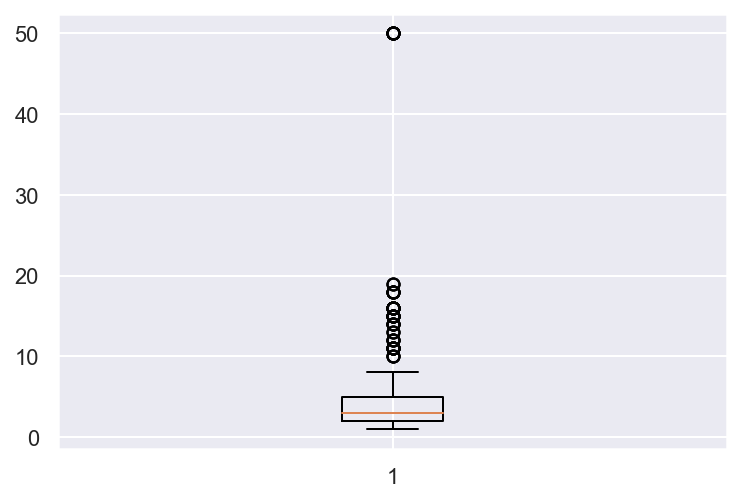

In [158]:
plt.boxplot(df['버스정류장'])
plt.show()

In [159]:
q25 = np.percentile(df['버스정류장'], 25)
q75 = np.percentile(df['버스정류장'], 75)
IQR = q75 - q25
df['버스정류장'] = np.where(df['버스정류장'] > 7, 7, df['버스정류장'])

In [160]:
np.mean(df['버스정류장']) 

3.7331349206349205

(array([115., 252.,   0., 158.,   0., 134., 112.,   0.,  85., 152.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

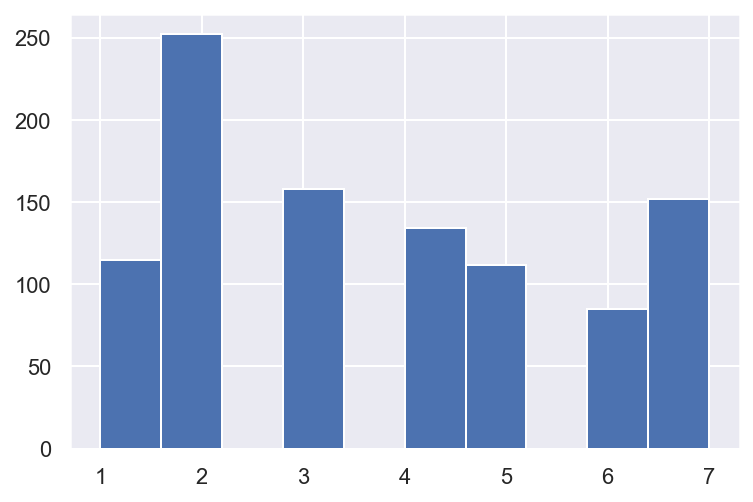

In [161]:
plt.hist(df['버스정류장'])

In [162]:
df.to_csv('data/test_1_semi.csv', index=False)

In [163]:
#전처리 완료
df = pd.read_csv('data/test_1_semi.csv')

## 4.그룹

### 공급유형 그룹

In [164]:
df['period'] = np.where((df.공급유형=='영구임대')|(df.공급유형=='공공임대(50년)')|(df.공급유형=='공공분양'), 'exL',
        np.where((df.공급유형=='국민임대')|(df.공급유형 =='장기전세'), 'L', 'S'))

In [165]:
# from collections import Counter

(array([614.,   0.,   0.,   0.,   0.,  56.,   0.,   0.,   0., 338.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

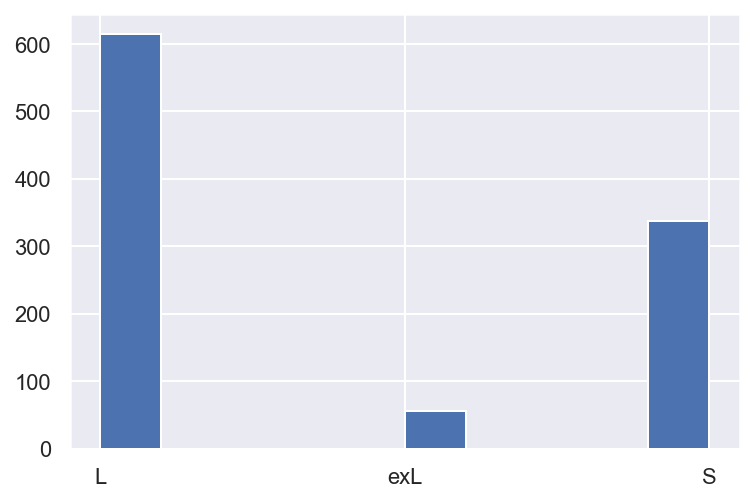

In [166]:
plt.hist(df.period)

### 자격유형 그룹

In [167]:
ls=[]
for i in df.공급유형.unique():
    temp = df[df.공급유형 == i]
    cert = temp.자격유형.unique()
    ls.append([i, cert])

- A : 공공임대(50년), 공공임대(10년), 공공임대(분납), 장기전세, 공공임대(5년) - 
- D : 임대상가, 공공분양 - 
- A, C, E, F, I : 영구임대
- J, K, L, M, N, O : 행복주택
- A, B, E, G, H : 국민임대

In [168]:
df['자격유형_cat'] = np.where(df.공급유형 =='행복주택', 'JKLMNO',
        np.where(df.공급유형 == '국민임대', 'ABEGH',
                np.where(df.공급유형 =='영구임대', 'ACEFI',
                        np.where((df.공급유형 =='임대상가') | (df.공급유형 =='공공분양'), 'D', 'A'))))

In [169]:
df['자격유형_cat'].unique()

array(['ABEGH', 'ACEFI', 'D', 'A', 'JKLMNO'], dtype=object)

(array([614.,   0.,  43.,   0.,   0., 177.,   0.,  54.,   0., 120.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

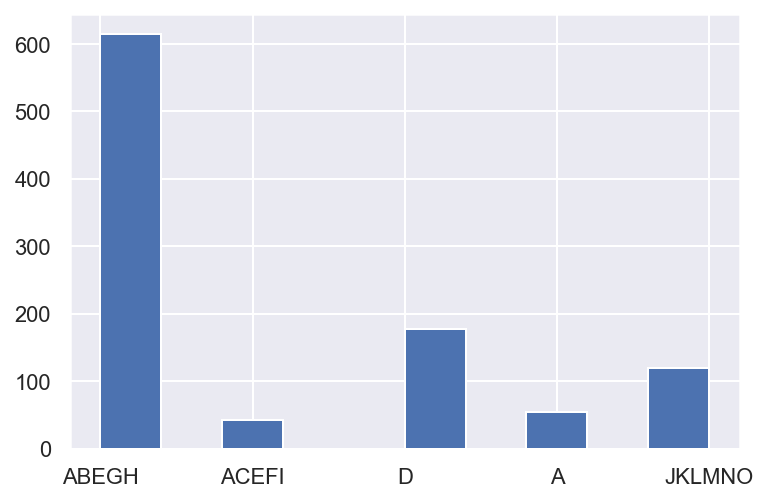

In [170]:
plt.hist(df['자격유형_cat'])

### 전용면적 그룹
- 상한선 100, 하한선 15

In [171]:
df.전용면적.describe()

count    1008.000000
mean       43.788462
std        36.105647
min         9.960000
25%        33.150000
50%        39.720000
75%        47.410000
max       583.400000
Name: 전용면적, dtype: float64

In [172]:
df['전용면적'] = df.전용면적//5 *5

In [173]:
df.전용면적 = np.where(df.전용면적 > 80, 80,
        np.where(df.전용면적 < 15, 15, df.전용면적))
df.전용면적 = df.전용면적.astype('int64')

In [174]:
df.전용면적.describe()

count    1008.000000
mean       38.611111
std        13.228027
min        15.000000
25%        30.000000
50%        35.000000
75%        45.000000
max        80.000000
Name: 전용면적, dtype: float64

(array([109., 129.,  41., 285., 205., 136.,  68.,   0.,   8.,  27.]),
 array([15. , 21.5, 28. , 34.5, 41. , 47.5, 54. , 60.5, 67. , 73.5, 80. ]),
 <BarContainer object of 10 artists>)

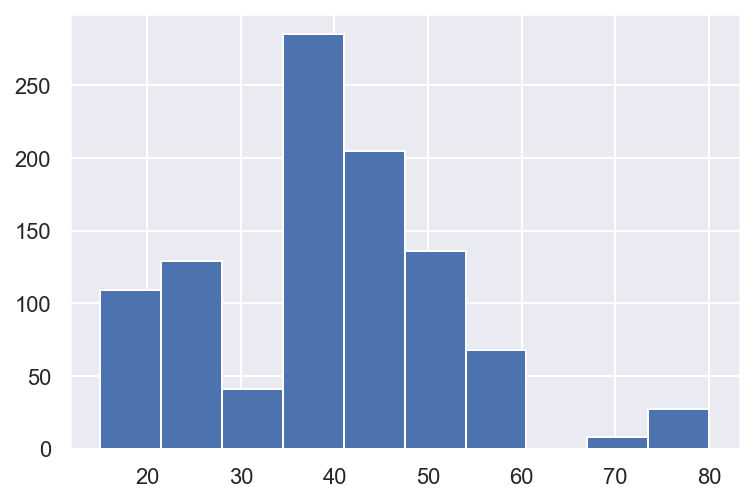

In [175]:
plt.hist(df.전용면적)

# 5. 데이터프레임 만들기 시작

In [176]:
df1 = pd.DataFrame(df.groupby('단지코드').sum().reset_index()['단지코드'], columns=['단지코드']) #단지코드 데이터프레임

## 1)임대건물구분

### 아파트/상가 세대수

In [177]:
df1 = pd.DataFrame(df.groupby('단지코드').sum()['전용면적별세대수'].reset_index()['단지코드'], columns = ['단지코드'])
temp = df.groupby(['단지코드', '임대건물구분']).sum()['전용면적별세대수'].reset_index()

df1 = df1.merge(temp.loc[temp['임대건물구분'] == '아파트'].reset_index(drop=True)[['단지코드','전용면적별세대수']], on = '단지코드', how = 'left')

df1.columns = ['단지코드','아파트세대수']

df1 = df1.merge(temp.loc[temp['임대건물구분'] == '상가'].reset_index(drop=True)[['단지코드','전용면적별세대수']], on = '단지코드', how = 'left' )

df1.columns = ['단지코드','아파트세대수', '상가세대수']

df1 = df1.fillna(0)

### 총세대수 & 아파트/상가 비율

In [178]:
# temp = df[['단지코드', '총세대수']].drop_duplicates() #총세대수
# df1 = df1.merge(temp, on='단지코드', how='left')

In [179]:
df1['총세대수'] = df1['아파트세대수'] + df1['상가세대수']

In [180]:
df1['아파트비율'] = df1['아파트세대수']/df1['총세대수']
df1['상가비율'] = df1['상가세대수']/df1['총세대수']

In [181]:
df1 = df1.drop(['아파트세대수', '상가세대수'], axis=1)

## 2) 기본정보

In [182]:
#제외 : 총세대수, 임대건물구분(df1), 전용면적별세대수, 전용면적, 공급유형, 자격유형
#포함 : 단지코드, 지역, 공가수, 도보 10분거리 내 지하철역 수(환승노선 수 반영),  도보 10분거리 내 버스정류장 수, 단지내주차면수, 등록차량수

In [183]:
temp = df[['단지코드', '지역', '공가수', '지하철역',
                     '버스정류장', '단지내주차면수']].drop_duplicates()
df1=df1.merge(temp, on='단지코드', how='left')

In [184]:
#비율만
df1.columns = ['단지코드', '총세대수', '아파트비율', '상가비율', '지역', '공가수',
       '지하철역', '버스정류장', '단지내주차면수']

## 3) 전용면적

### 전용면적 세대수 
- 10번 후에 삭제

In [185]:
for i in df.sort_values('전용면적').전용면적.unique():
    temp = df[df.전용면적 ==i].groupby('단지코드').sum().reset_index()[['단지코드', '전용면적별세대수']]
    temp.columns = ['단지코드', '전용면적_{}_세대수'.format(i)]
    df1 = df1.merge(temp,on='단지코드', how='left')
    
df1 = df1.fillna(0)

In [186]:
df1.columns

Index(['단지코드', '총세대수', '아파트비율', '상가비율', '지역', '공가수', '지하철역', '버스정류장',
       '단지내주차면수', '전용면적_15_세대수', '전용면적_20_세대수', '전용면적_25_세대수', '전용면적_30_세대수',
       '전용면적_35_세대수', '전용면적_40_세대수', '전용면적_45_세대수', '전용면적_50_세대수',
       '전용면적_55_세대수', '전용면적_60_세대수', '전용면적_70_세대수', '전용면적_75_세대수',
       '전용면적_80_세대수'],
      dtype='object')

### 전용면적 비율 ★

In [187]:
ls = ['전용면적_15_세대수', '전용면적_20_세대수', '전용면적_25_세대수', '전용면적_30_세대수',
       '전용면적_35_세대수', '전용면적_40_세대수', '전용면적_45_세대수', '전용면적_50_세대수',
       '전용면적_55_세대수', '전용면적_60_세대수', '전용면적_70_세대수', '전용면적_75_세대수',
       '전용면적_80_세대수']

In [188]:
ls1 = df.sort_values('전용면적').전용면적.unique()
for i in ls1:
    df1['전용면적_{}_비율'.format(i)] = df1['전용면적_{}_세대수'.format(i)] / df1['총세대수']

## 4) 공급유형

### 공급유형 cat 비율

In [189]:
df2 = pd.DataFrame(df.groupby('단지코드').sum().reset_index()['단지코드'], columns=['단지코드']) #단지코드 데이터프레임

temp = df.groupby(['단지코드', 'period']).sum().reset_index()

temp1 = temp.loc[temp['period'] == 'exL'][['단지코드', '전용면적별세대수']]
temp1.columns = ['단지코드', '초장기세대수']
df2 = df2.merge(temp1, on = '단지코드', how = 'left')

temp2 = temp.loc[temp['period'] == 'L'][['단지코드', '전용면적별세대수']]
temp2.columns = ['단지코드', '장기세대수']
df2 = df2.merge(temp2, on = '단지코드', how = 'left')

temp3 = temp.loc[temp['period'] == 'S'][['단지코드', '전용면적별세대수']]
temp3.columns = ['단지코드', '단기세대수']
df2 = df2.merge(temp3, on = '단지코드', how = 'left')

df2 = df2.fillna(0)

In [190]:
df2['총세대수'] = df2['초장기세대수'] + df2['장기세대수'] + df2['단기세대수']
df2['초장기비율'] = df2['초장기세대수'] / df2['총세대수']
df2['장기비율'] = df2['장기세대수'] / df2['총세대수']
df2['단기비율'] = df2['단기세대수'] / df2['총세대수']
df2 = df2.drop(['초장기세대수', '장기세대수', '단기세대수', '총세대수'], axis=1)
df1 = df1.merge(df2, on='단지코드', how='left')

## 5) 자격유형

### 자격유형cat 비율

In [191]:
df['자격유형_cat'].unique()

array(['ABEGH', 'ACEFI', 'D', 'A', 'JKLMNO'], dtype=object)

In [192]:
df2 = pd.DataFrame(df.groupby('단지코드').sum().reset_index()['단지코드'], columns=['단지코드']) #단지코드 데이터프레임

temp = df.groupby(['단지코드', '자격유형_cat']).sum().reset_index()

temp1 = temp.loc[temp['자격유형_cat'] == 'ABEGH'][['단지코드', '전용면적별세대수']]
temp1.columns = ['단지코드', 'ABEGH세대수']
df2 = df2.merge(temp1, on = '단지코드', how = 'left')

temp2 = temp.loc[temp['자격유형_cat'] == 'A'][['단지코드', '전용면적별세대수']]
temp2.columns = ['단지코드', 'A세대수']
df2 = df2.merge(temp2, on = '단지코드', how = 'left')

temp3 = temp.loc[temp['자격유형_cat'] == 'ACEFI'][['단지코드', '전용면적별세대수']]
temp3.columns = ['단지코드', 'ACEFI세대수']
df2 = df2.merge(temp3, on = '단지코드', how = 'left')

temp4 = temp.loc[temp['자격유형_cat'] == 'D'][['단지코드', '전용면적별세대수']]
temp4.columns = ['단지코드', 'D세대수']
df2 = df2.merge(temp4, on = '단지코드', how = 'left')

temp5 = temp.loc[temp['자격유형_cat'] == 'JKLMNO'][['단지코드', '전용면적별세대수']]
temp5.columns = ['단지코드', 'JKLMNO세대수']
df2 = df2.merge(temp5, on = '단지코드', how = 'left')

df2 = df2.fillna(0)

df2['총세대수'] = df2.iloc[:, 1] + df2.iloc[:, 2] + df2.iloc[:, 3] + df2.iloc[:, 4] + df2.iloc[:, 5]
df2['ABEGH비율'] = df2['ABEGH세대수'] / df2['총세대수']
df2['A비율'] = df2['A세대수'] / df2['총세대수']
df2['ACEFI비율'] = df2['ACEFI세대수'] / df2['총세대수']
df2['D비율'] = df2['D세대수'] / df2['총세대수']
df2['JKLMNO비율'] = df2['JKLMNO세대수'] / df2['총세대수']

In [193]:
df2 = df2.drop(['ABEGH세대수', 'A세대수', 'ACEFI세대수', 'D세대수', 'JKLMNO세대수', '총세대수'], axis=1)

In [194]:
df1 = df1.merge(df2, on='단지코드', how='left')

## 6) 나이/성별 인구수
- 나이대별로 합치는건 결과에 그다지 영향 안 미침. 그대로 붙여도 무관

In [195]:
ageinfo = pd.read_csv('data/age_gender_info.csv')
df1 = df1.merge(ageinfo, on = '지역', how = 'left')

## 7) 1인당 자동차등록수

In [196]:
car_2019 = pd.read_csv('data/1인당자동차_2019.csv', encoding='euc-kr', header=1)

In [197]:
car_2019.columns = ['지역', '1인당_자동차등록대수', '자동차등록대수', '주민등록인구']
car_2019['1인당자동차'] = car_2019.자동차등록대수 / car_2019.주민등록인구
car_2019 = car_2019[['지역', '1인당자동차']]
df1 = df1.merge(car_2019, on='지역', how='left')

## 8) 주택연면적

In [198]:
size = pd.read_csv('data/주택연면적_2019.csv', encoding='euc-kr', header=1)

In [199]:
size = size[['행정구역별(시군구)', '2019년']].iloc[4:, :].reset_index(drop=True)
size.columns = ['지역', '연면적']

In [200]:
df1 = df1.merge(size, on='지역', how='left')

## 9) 평당가격

In [201]:
price = pd.read_csv('data/평균분양가격_2019.csv', encoding='euc-kr', header=1)
price = price[['지역별(2)', '전체.11']]
price = price.iloc[2:, :]
idx = price.index.difference([5]).difference([12]).difference([3]).difference([2])
price = price.loc[idx, :].reset_index(drop=True)
price.columns = ['지역', '평균분양가격']
price = price.sort_values('지역').reset_index(drop=True)
price['지역'] = df.sort_values('지역').지역.unique()

In [202]:
df1 = df1.merge(price, on='지역', how='left')

## 10) 총면적구하기 ★
- 전용면적별 세대수 사용

In [203]:
size_ls = df.sort_values('전용면적')['전용면적'].unique()

In [204]:
len(size_ls) #65 전용면적 없어서 1개 적음.

13

In [205]:
all_size=0
for i in range(13):
    all_size += df1.iloc[:,i+9] * size_ls[i]

In [206]:
df1['총면적'] = all_size

In [207]:
df1 = df1.drop(ls, axis=1) #전용면적세대수 없애주기

## 11) 규모별 가격

In [208]:
df1['규모별가격'] = df1['총면적'] * df1['평균분양가격']

In [220]:
df1.shape

(147, 73)

## 12) 자전거도로

In [210]:
bicycle = pd.read_csv('data/자전거도로_2019.csv', encoding='euc-kr', header=1)
bicycle = bicycle.iloc[:, :2]
bicycle.columns = ['지역', '자전거도로']
bicycle['전국'] =23849.87
bicycle['자전거도로비율'] = bicycle.자전거도로 / bicycle.전국
bicycle = bicycle.iloc[1:, :]
bicycle = bicycle.drop(['자전거도로', '전국'], axis=1)

In [211]:
df1 = df1.merge(bicycle, on='지역', how='left')

## 13) 운전면허소지자현황

In [212]:
driver = pd.read_csv('data/운전면허소지자현황.csv', encoding='euc-kr')
driver = driver.iloc[3:, :2].reset_index(drop=True)
driver['2019'] = driver['2019'].astype('int64')
경기 = driver.iloc[7, :] + driver.iloc[8, :]
driver.iloc[7, :] = 경기
driver.iloc[8, :] = 경기
driver = driver.drop_duplicates()
driver.columns = ['지역', '운전면허소지자현황']
idx = driver.index.difference([3]).difference([0])
driver = driver.loc[idx, :].reset_index(drop=True)
driver = driver.sort_values('지역').reset_index(drop=True)
driver.지역 = df.sort_values('지역').지역.unique()
driver['운전면허소지자비율'] = driver['운전면허소지자현황'].apply(lambda x : x/driver.운전면허소지자현황.sum())
driver = driver.drop('운전면허소지자현황', axis=1)

In [213]:
df1 = df1.merge(driver, on='지역', how='left')

## 14) 지역인코딩

In [214]:
df1 = pd.concat([df1.drop('지역', axis = 1),pd.get_dummies(df1.지역)], axis = 1)

## 15) test data 저장

In [215]:
# df1.to_csv('data/test_ratio_0728.csv', index=False)

In [219]:
df1 = pd.read_csv('data/test_try0728_2.csv')